In [2]:
import wave
import numpy as np
import scipy.signal as sg
from pathlib import Path
import matplotlib.pyplot as plt
import math

def calc_array_manifold_vector(theta, n_mic, n_bin, fs, N, c):
    # ysinΘ + xcosΘ
    """
    a: i x n_mic x 1 x n_bin
       方向数 x マイク数 x 1 x 周波数ビン数
    """
    rc = 0.0365
    mic_angle = np.array(
        [
            0,
            -np.pi / 4,
            -np.pi / 2,
            -np.pi * 3 / 4,
            np.pi,
            np.pi * 3 / 4,
            np.pi * 1 / 2,
            np.pi * 1 / 4,
        ]
    )
    a = np.zeros((theta.shape[0], n_mic, 1, n_bin), dtype=np.complex64)
    for i, th in enumerate(theta):
        th = np.radians(th)
        for k in range(n_bin):
            fk = fs * k / N
            for m in range(n_mic):
                delay = -rc * np.cos(th - mic_angle[m]) / c
                a[i, m, 0, k] = np.exp(-1j * 2 * np.pi * fk * delay)
    return a


def load_onefile(file_name):
    """
    return M x frames ndarray
    """
    wav = wave.open(file_name)
    # print("sample width:", wav.getsampwidth())
    # print("channel num:", wav.getnchannels())
    # print("frames:", wav.getnframes())

    M = wav.getnchannels()

    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data / np.iinfo(np.int16).max

    multi_data = data.reshape(-1, M)
    multi_data = np.transpose(multi_data)
    # print("multi_data.shape:", multi_data.shape)

    wav.close()

    return multi_data

def lower_bound(arr, num):
    left = 0
    right = len(arr) - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] <= num:
            left = mid + 1
        if arr[mid] > num:
            right = mid - 1
    # print("left: ", left, " right: ", right)
    return right


def MUSIC(file_name, t_left_sec, t_right_sec, start_angle, end_angle):
    n_mic = 8
    n_src = 3
    N = 512
    window = "hann"
    c = 340
    freq_l = 300
    freq_h = 1500

    fs = 16000
    k_l = int(freq_l / (fs / N))
    k_h = int(freq_h / (fs / N))

    audio = load_onefile(file_name)

    # print(audio.shape)
    f, t, X = sg.stft(audio, fs, window=window, nperseg=N)
    n_bin = X.shape[1]
    print(t)
    t_left_index = lower_bound(t, t_left_sec)
    t_right_index = lower_bound(t, t_right_sec)

    theta = np.linspace(
        start_angle, end_angle, num=((end_angle - start_angle) // 5) + 1
    )
    P_MU = np.zeros(theta.shape[0])

    a = calc_array_manifold_vector(theta, n_mic, n_bin, fs, N, c)
    # print(X.shape)
    X_trimed = X[:, :, t_left_index:t_right_index]
    XH = np.conjugate(X_trimed)
    XXH = np.einsum("mki,nki->mnki", X_trimed, XH)
    R = np.mean(XXH, axis=3)

    eig_val = np.zeros((n_mic, n_bin), dtype=np.complex64)
    eig_vec = np.zeros((n_mic, n_mic, n_bin), dtype=np.complex64)
    beta = np.zeros(n_bin)
    for k in range(n_bin):
        eig_val_k, eig_vec_k = np.linalg.eig(
            R[:, :, k]
        )  # 周波数ごとに固有値、固有ベクトルを算出
        sort = np.argsort(-1.0 * np.abs(eig_val_k))
        eig_val[:, k] = eig_val_k[sort]
        eig_vec[:, :, k] = eig_vec_k[:, sort]

    W = eig_vec[:, n_src:, :]
    beta = np.sum(np.abs(eig_val[:n_src, :]), axis=0)

    for i, th in enumerate(theta):
        aH = np.conjugate(a[i])
        aHa = np.einsum("mik,mjk->ijk", aH, a[i])
        P_MU_th = np.einsum("mik,mek->iek", aH, W)
        P_MU_th = np.einsum("iek,jek->ijk", P_MU_th, np.conjugate(P_MU_th))
        P_MU_th = np.abs(aHa) / np.abs(P_MU_th)
        P_MU[i] = np.mean(beta[k_l : k_h + 1] * P_MU_th[0, 0, k_l : k_h + 1])

    P_MU = 10 * np.log10(P_MU)

    return P_MU


def make_sec_list(sec_left, sec_right, odd):
  ret = np.array([], dtype=float)
  while(sec_left <= sec_right):
    ret = np.append(ret, sec_left)
    sec_left += odd
  return ret

def display_one_file(file_name, sec_left, sec_right):
  plt.figure(figsize=(24, 16))
  start_angle = -180
  end_angle = 180
  theta = np.linspace(start_angle, end_angle, num=((end_angle-start_angle) // 5) + 1)
  theta = np.deg2rad(theta)
  
  t_sec_list_1 = make_sec_list(sec_left, sec_right, 0.2)
  interval_num = t_sec_list_1.shape[0]-1
  row_num = 5
  col_num = interval_num // row_num + 1

  for i in range(interval_num):
    P_MU = MUSIC(file_name, t_left_sec=t_sec_list_1[i], t_right_sec=t_sec_list_1[i+1], start_angle=start_angle, end_angle=end_angle)
    ax = plt.subplot(
      row_num, col_num, i+1, projection="polar"
    )
    ax.plot(theta, P_MU)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
def display_one_scene(file_name, sec_left, sec_right):
  plt.figure(figsize=(5, 3))
  start_angle = -180
  end_angle = 180
  theta = np.linspace(start_angle, end_angle, num=((end_angle-start_angle) // 5) + 1)
  theta = np.deg2rad(theta)
  P_MU = MUSIC(file_name, t_left_sec=sec_left, t_right_sec=sec_right, start_angle=start_angle, end_angle=end_angle)
  ax = plt.subplot(
    1, 1, 1, projection="polar"
  )
  ax.plot(theta, P_MU)
  ax.set_theta_zero_location("N")
  ax.set_theta_direction(-1)

def compare_two_file(file_name_1, sec_left_1,  sec_right_1, file_name_2, sec_left_2, sec_right_2):
  plt.figure(figsize=(24, 16))
  start_angle = -180
  end_angle = 180
  theta = np.linspace(start_angle, end_angle, num=((end_angle-start_angle) // 5) + 1)
  theta = np.deg2rad(theta)
  
  t_sec_list_1 = make_sec_list(sec_left_1, sec_right_1, 0.2)
  interval_num = t_sec_list_1.shape[0]-1
  row_num = 5
  col_num = interval_num // row_num + 1

  for i in range(interval_num):
    P_MU = MUSIC(file_name_1, t_left_sec=t_sec_list_1[i], t_right_sec=t_sec_list_1[i+1], start_angle=start_angle, end_angle=end_angle)
    ax = plt.subplot(
      row_num, col_num, i+1, projection="polar"
    )
    ax.plot(theta, P_MU, color="blue")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
  t_sec_list_2 = make_sec_list(sec_left_2, sec_right_2, 0.2)
  interval_num = t_sec_list_2.shape[0]-1
  row_num = 5
  col_num = interval_num // row_num + 1
  
  print(row_num)
  print(col_num)

  for i in range(interval_num):
    P_MU = MUSIC(file_name_2, t_left_sec=t_sec_list_2[i], t_right_sec=t_sec_list_2[i+1], start_angle=start_angle, end_angle=end_angle)
    ax = plt.subplot(
      row_num, col_num, i+1, projection="polar"
    )
    ax.set_xlabel(str(round(t_sec_list_2[i], 1)))
    ax.plot(theta, P_MU, color="red")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
def compare_two_file_district(file_name_1, sec_left_1,  sec_right_1, file_name_2, sec_left_2, sec_right_2, one=False):
  start_angle = -180
  end_angle = 180
  theta_num = np.linspace(start_angle, end_angle, num=((end_angle-start_angle) // 5) + 1)
  theta = np.deg2rad(theta_num)

  P_MU_1 = MUSIC(file_name_1, t_left_sec=sec_left_1, t_right_sec=sec_right_1, start_angle=start_angle, end_angle=end_angle)
  
  P_MU_2 = MUSIC(file_name_2, t_left_sec=sec_left_2, t_right_sec=sec_right_2, start_angle=start_angle, end_angle=end_angle)
  
  fig, ax1 = plt.subplots(figsize=(5,3))
  
  ax1.plot(theta_num, P_MU_1, "b-", label="spec1")
  ax1.set_xlabel("Angle sec:" + str(round(sec_left_1, 1)))
  ax1.set_ylabel("spec1")
  ax1.tick_params(axis="y", labelcolor="b")
  
  ax2 = ax1.twinx()
  ax2.plot(theta_num, P_MU_2, "r-", label="spec2")
  ax2.set_ylabel("spec2", color="r")
  ax2.tick_params(axis="y", labelcolor="r")
  
  fig.suptitle('Comparison of Two Spatial Spectra with Different Y-Axes')
  ax1.grid(True)
  ax1.set_xlim(-180, 180)
  ax1.set_xticks(np.arange(-180, 185, 30))
  
  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
  plt.show()
  
def one_file_visualize(file_name, sec_left, sec_right):
  start_angle = -180
  end_angle = 180
  theta_num = np.linspace(start_angle, end_angle, num=((end_angle-start_angle) // 5) + 1)
  theta = np.deg2rad(theta_num)
  P_MU = MUSIC(file_name, t_left_sec=sec_left, t_right_sec=sec_right, start_angle=start_angle, end_angle=end_angle)
  plt.figure(figsize=(5, 3))
  plt.plot(theta_num, P_MU, "b-")
  plt.xlabel("Angle sec:" +  str(round(sec_left, 1)))
  plt.ylabel("spec")
  plt.grid(True)
  plt.xlim(-180, 180)
  plt.xticks(np.arange(-180, 185, 30))
  
def MUSIC_indexbase(file_name, t_left_sec, t_right_sec, interval,  start_angle, end_angle, N, noverlap=None):
  """
  N: nperseg，窓関数の適用間隔
      noverlapは指定されなかった場合，デフォルトでnpersegの1/2になる
  """
  
  
  n_mic = 8
  n_src = 3
  window = "hann"
  c = 340
  freq_l = 300
  freq_h = 1500

  fs = 16000
  k_l = int(freq_l / (fs / N))
  k_h = int(freq_h / (fs / N))

  audio = load_onefile(file_name)

  # print(audio.shape)」
  if noverlap == None:
    noverlap = N / 2 
  
  # X: マイク数 x 周波数インデックス x 時間インデックス
  f, t, X = sg.stft(audio, fs, window=window, nperseg=N, noverlap=noverlap)
  n_bin = X.shape[1]
  
  t_left_index = (int)(t_left_sec // ((N - noverlap)/fs))
  t_right_index = (int)((t_right_sec + ((N - noverlap) / fs)) // ((N - noverlap) / fs))
  print(f"t_left_index: {t_left_index}")
  print(f"t_right_index: {t_right_index}")
  
  theta = np.linspace(
      start_angle, end_angle, num=((end_angle - start_angle) // 5) + 1
  )
  P_MU_LIST = None
  TIME_RANGE_LIST = None
  
  a = calc_array_manifold_vector(theta, n_mic, n_bin, fs, N, c)
  
  # t_left_index から interval　分だけインデックスをずらす t_right_index に到達するまで
  # ループ
  # やること：とりあえずtrim処理以下をまんまループに入れて実行
  # 書きかけて気づいたけど，特定範囲でのMUSICスペクトルを適宜出してほしい
  # ↑いやそんなことはない
  # 　まとめて処理して時間インデックスを持ってればいい
  #対応する時間範囲もreturnすればいいかも
  while t_left_index < t_right_index:
    P_MU = np.zeros((theta.shape[0], f.shape[0]))
    # print(X.shape)
    X_trimed = X[:, :, t_left_index:(t_left_index+interval)]
    time_range = np.array([[t[t_left_index], t[t_left_index+interval]]])
    XH = np.conjugate(X_trimed)
    XXH = np.einsum("mki,nki->mnki", X_trimed, XH)
    R = np.mean(XXH, axis=3) # ここで時間平均を取っている(時間範囲での期待値に相当)

    eig_val = np.zeros((n_mic, n_bin), dtype=np.complex64)
    eig_vec = np.zeros((n_mic, n_mic, n_bin), dtype=np.complex64)
    beta = np.zeros(n_bin)
    for k in range(n_bin):
        eig_val_k, eig_vec_k = np.linalg.eig(
            R[:, :, k]
        )  # 周波数ごとに固有値、固有ベクトルを算出
        sort = np.argsort(-1.0 * np.abs(eig_val_k))
        eig_val[:, k] = eig_val_k[sort]
        eig_vec[:, :, k] = eig_vec_k[:, sort]

    W = eig_vec[:, n_src:, :]
    beta = np.sum(np.abs(eig_val[:n_src, :]), axis=0) # 固有値は各周波数のパワーなので，それを用いた重み付けのための項 参考：https://nettyukobo.com/music/

    for i, th in enumerate(theta):
        aH = np.conjugate(a[i])
        aHa = np.einsum("mik,mjk->ijk", aH, a[i])
        P_MU_th = np.einsum("mik,mek->iek", aH, W)
        P_MU_th = np.einsum("iek,jek->ijk", P_MU_th, np.conjugate(P_MU_th))
        P_MU_th = np.abs(aHa) / np.abs(P_MU_th)# ?
        P_MU[i] = np.mean(beta[k_l : k_h + 1] * P_MU_th[0, 0, k_l : k_h + 1]) # 重み付けの計算，要素ごとの積をした後meanで1つの値に
    
    if P_MU_LIST is None:
      P_MU_LIST = P_MU[np.newaxis, :, :]
    else:
      P_MU_LIST = np.concatenate((P_MU_LIST, [P_MU]), axis=0)
    
    if TIME_RANGE_LIST is None:
      TIME_RANGE_LIST = time_range
    else:
      TIME_RANGE_LIST = np.concatenate((TIME_RANGE_LIST, time_range), axis=0)
    
    t_left_index += interval

  # P_MU = 10 * np.log10(P_MU)

  return P_MU_LIST, TIME_RANGE_LIST

def calculate_interval_sec(interval, fs, N, noverlap=None):
  if noverlap == None:
    noverlap = N / 2
  print(f"interval is {((N - noverlap) / fs) * interval} sec.")
  
def display_one_file_indexbase(P_MU_LIST, TIME_RANGE_LIST):
  plt.figure(figsize=(24, 16))
  start_angle = -180
  end_angle = 180
  theta = np.linspace(start_angle, end_angle, num=((end_angle-start_angle) // 5) + 1)
  theta = np.deg2rad(theta)
  
  P_MU_LIST_log = 10 * np.log10(P_MU_LIST)
  
  col_num = 5
  row_num = P_MU_LIST.shape[0] // 5 + 1

  for i in range(P_MU_LIST.shape[0]):

    ax = plt.subplot(
      row_num, col_num, i+1, projection="polar"
    )
    ax.plot(theta, P_MU_LIST[i])
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    

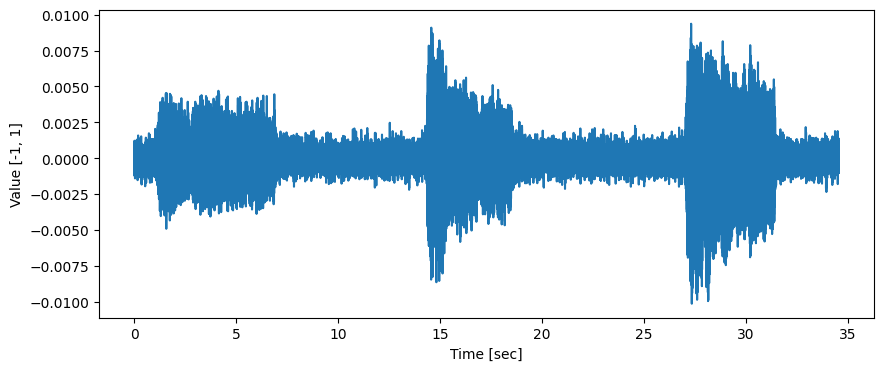

In [4]:
file_name = "/home/nishimura-k/audioprocessing/datas/audio_datas/30_-60_0.wav"
sample_rate = 16000
audio = load_onefile(file_name)

x = np.array(range(audio.shape[1])) / sample_rate

plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1, 1]")
plt.plot(x, audio[0])

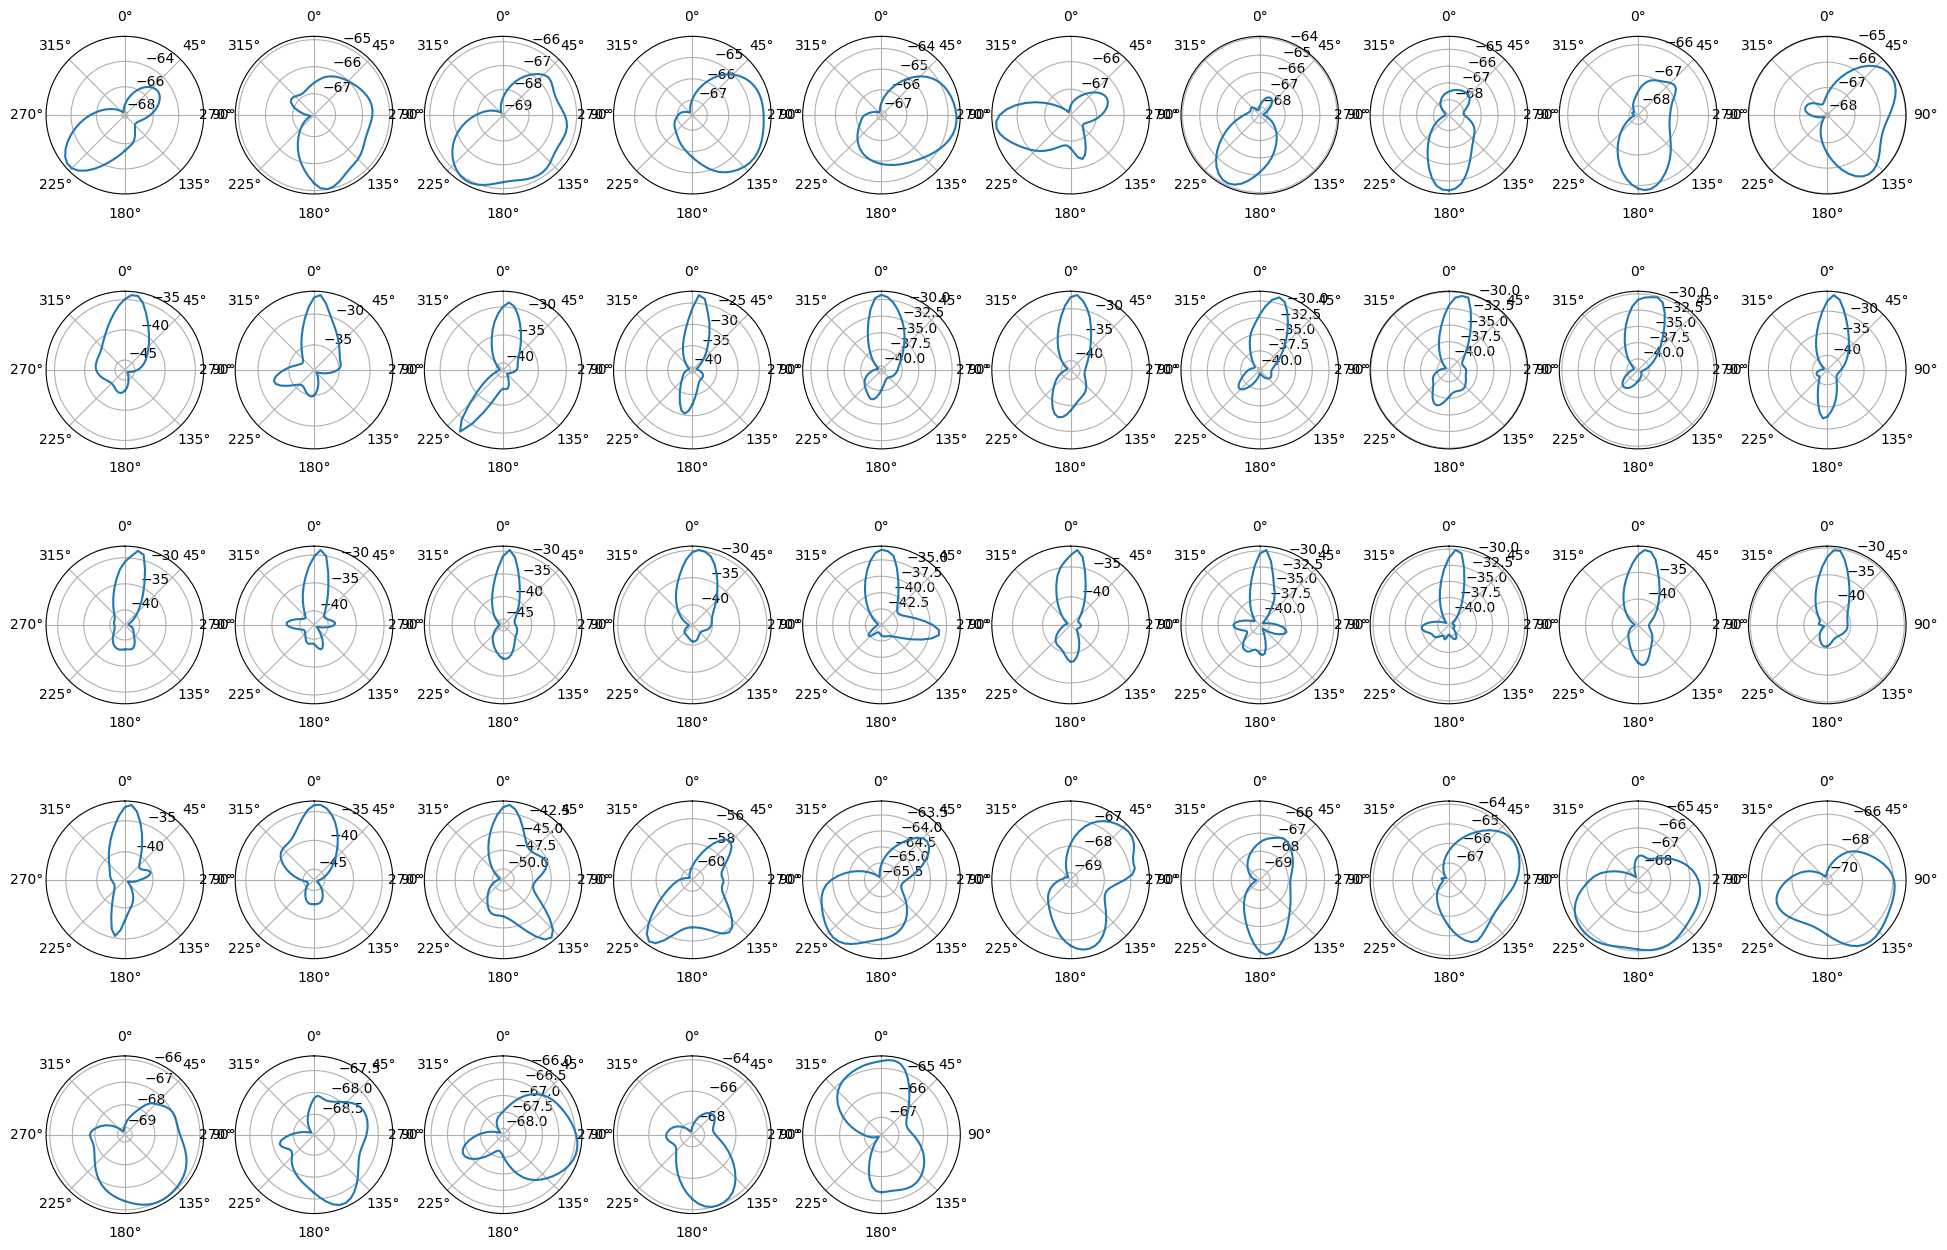

In [9]:
sec_left = 25
sec_right = 34
display_one_file(file_name, sec_left, sec_right)

In [6]:
file_name = "/home/nishimura-k/audioprocessing/datas/audio_datas/30_-60_0.wav"
MUSIC(file_name, t_left_sec=25, t_right_sec=34, start_angle=-180, end_angle=180)

[0.0000e+00 1.6000e-02 3.2000e-02 ... 3.4544e+01 3.4560e+01 3.4576e+01]


array([-40.57848978, -40.30815055, -40.01251239, -39.71195197,
       -39.42627615, -39.16067959, -38.91033077, -38.67849991,
       -38.48616451, -38.37150813, -38.38278847, -38.55965646,
       -38.90841291, -39.39148084, -39.94471915, -40.50711969,
       -41.03704843, -41.51174358, -41.92066957, -42.25966543,
       -42.5269705 , -42.72053181, -42.83701705, -42.87234328,
       -42.82203293, -42.6809059 , -42.44254961, -42.09863199,
       -41.6380664 , -41.04585002, -40.30133576, -39.37572485,
       -38.22900953, -36.81075598, -35.09743718, -33.36126168,
       -32.26449188, -31.52565713, -31.52170958, -32.50443217,
       -34.09343228, -35.72795492, -37.15940382, -38.36087443,
       -39.3540108 , -40.16605213, -40.82048491, -41.3353596 ,
       -41.72355435, -41.99336316, -42.1492304 , -42.19287088,
       -42.12574263, -41.95548971, -41.71055077, -41.46053903,
       -41.30878531, -41.31917981, -41.45844961, -41.64046489,
       -41.79674544, -41.90013075, -41.9496077 , -41.95

In [7]:
window = "hann"
N = 512
fs = 16000
audio = load_onefile(file_name)

f, t, X = sg.stft(audio, fs, window=window, nperseg=N)
X.shape

(8, 257, 2162)

In [14]:
import numpy as np

array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])

print(array1 * array2)

array1 = np.array([[1], [2], [3]])
array2 = np.array([4, 5, 6])

print(array1 * array2)

array1 = np.array([1, 2, 3])
array2 = np.array([[4], [5], [6]])

print(array1 * array2)

[ 4 10 18]
[[ 4  5  6]
 [ 8 10 12]
 [12 15 18]]
[[ 4  8 12]
 [ 5 10 15]
 [ 6 12 18]]


In [17]:
import numpy as np
P_MU = np.array([[1, 2, 3], [4, 5, 6]])
P_MU_3D = P_MU[np.newaxis, :, :]

print(P_MU_3D)

P_MU_SECOND = np.array([[7, 8, 9], [10, 11, 12]])
P_MU_3D = np.concatenate((P_MU_3D, [P_MU_SECOND]), axis=0)
print(P_MU_3D)

P_MU_THIRD = np.array([[13, 14, 15], [16, 17, 18]])
P_MU_3D = np.concatenate((P_MU_3D, [P_MU_THIRD]), axis=0)
print(P_MU_3D)

[[[1 2 3]
  [4 5 6]]]
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]

 [[13 14 15]
  [16 17 18]]]


interval is 0.192 sec.
t_left_index: 874
t_right_index: 1250
P_MU_LIST.shape: (32, 73, 257)
TIME_RANGE_LIST.shape: (32, 2)


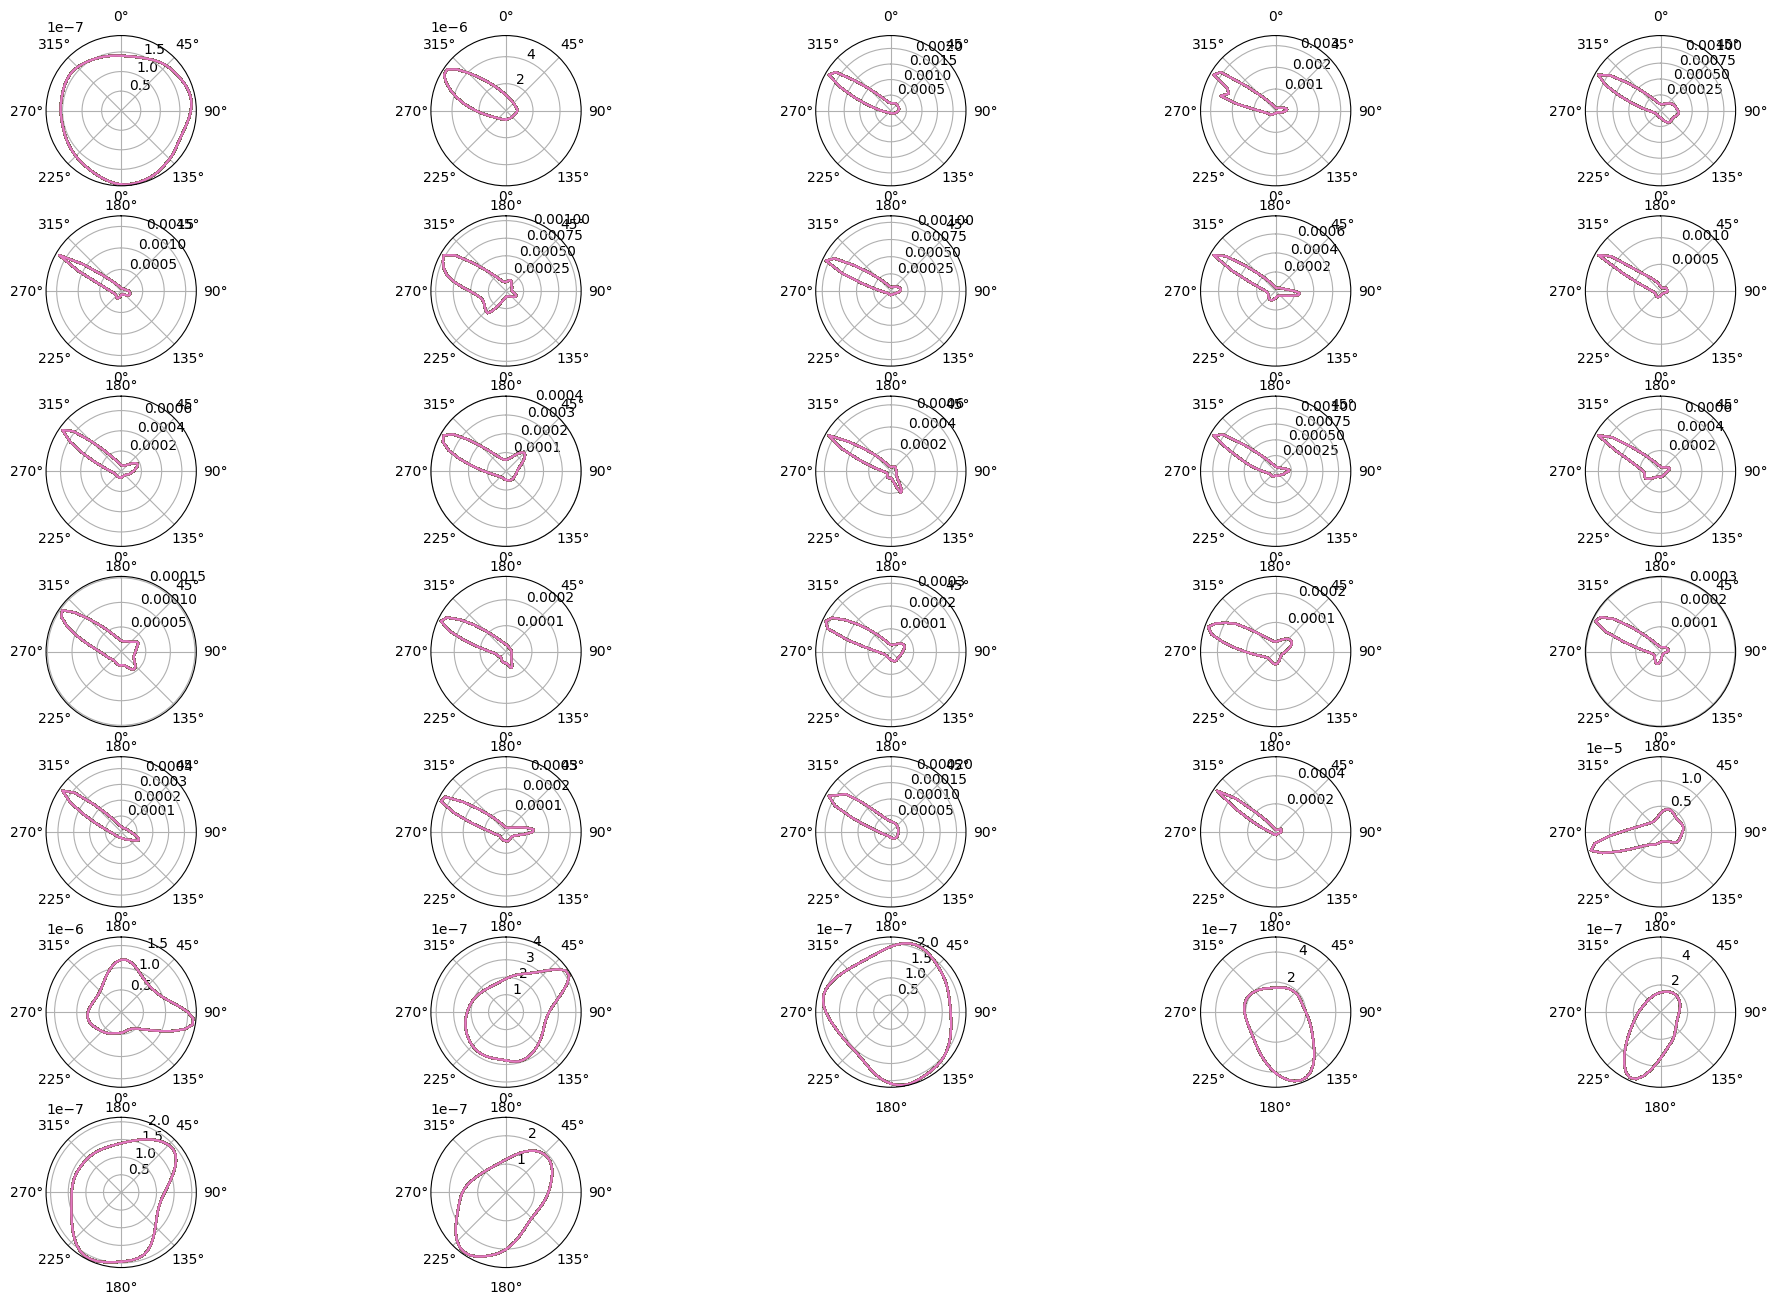

In [68]:
file_name = "/home/nishimura-k/audioprocessing/datas/audio_datas/30_-60_0.wav"

N = 512
interval = 12
fs = 16000
calculate_interval_sec(interval, fs, N)
P_MU_LIST, TIME_RANGE_LIST = MUSIC_indexbase(file_name, t_left_sec=14, t_right_sec=20, interval=interval, start_angle=-180, end_angle=180, N=N)

print(f"P_MU_LIST.shape: {P_MU_LIST.shape}")
print(f"TIME_RANGE_LIST.shape: {TIME_RANGE_LIST.shape}")

P_MU_LIST_log = 10 * np.log10(P_MU_LIST)

display_one_file_indexbase(P_MU_LIST, TIME_RANGE_LIST)

In [95]:
def binary_search_lower_bound(arr, num):
    left = 0
    right = len(arr) - 1
    count = 0
    while left < right:
        print(f"{count}. left: {left}, right: {right}")
        mid = (left + right) // 2
        if arr[mid] < num:
            left = mid + 1
        if arr[mid] >= num:
            right = mid
        count += 1
    return left
  
def binary_search(arr, num):
  left = 0
  right = len(arr) - 1
  count = 0
  while left <= right:
    print(f"{count}. left: {left}, right: {right}")
    mid = (left + right) // 2
    if arr[mid] <= num:
      left = mid + 1
    if arr[mid] > num:
      right = mid - 1
    count += 1
  return right
  
arr = [1, 2, 3, 4, 4, 4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4, 5, 7, 9, 10, 11, 12, 13, 15]
num = 4



print("Lower Bound:", binary_search_lower_bound(arr, num))  # 出力: 2 (最初の4の位置)
print("Binary Search:", binary_search(arr, num))

0. left: 0, right: 31
1. left: 0, right: 15
2. left: 0, right: 7
3. left: 0, right: 3
4. left: 2, right: 3
Lower Bound: 3
0. left: 0, right: 31
1. left: 16, right: 31
2. left: 24, right: 31
3. left: 24, right: 26
4. left: 24, right: 24
Binary Search: 23


In [98]:
import numpy as np
import pandas as pd

csv_file_name = "/home/nishimura-k/audioprocessing/datas/rosbag/to_csv_test_SB_harkwave_copy.csv"
csv_original_df = pd.read_csv(csv_file_name)
time_df = pd.read_csv(csv_file_name, usecols=["%time"], dtype={
  "%time":"int64"
})

time_ndarray = time_df.values
fixed_time_col = time_ndarray - time_ndarray[0]
fixed_time_col = fixed_time_col / (10 ** 9)

fixed_time_df = pd.DataFrame(data=fixed_time_col, columns=["fixed_time"], dtype="float64")
print(fixed_time_df)

csv_original_df["fixed_time"] = fixed_time_df
csv_original_df.to_csv("to_csv_test_SB_harkwave_updated.csv", index=False)


      fixed_time
0       0.000000
1       0.025323
2       0.050300
3       0.075328
4       0.100885
...          ...
1378   34.519393
1379   34.544371
1380   34.569255
1381   34.594283
1382   34.619263

[1383 rows x 1 columns]


(8, 480192)


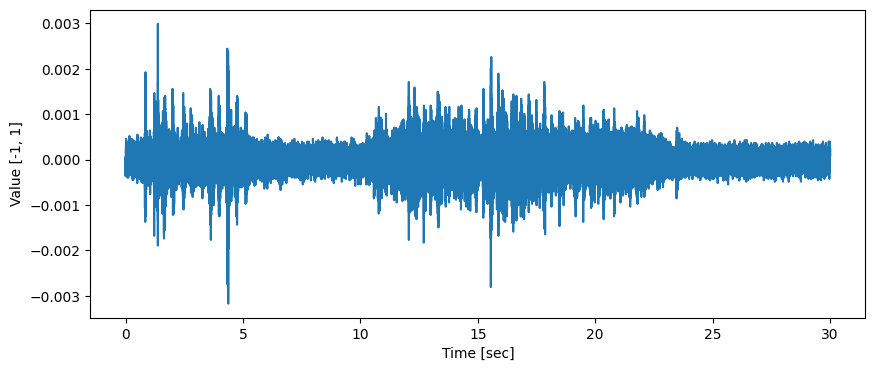

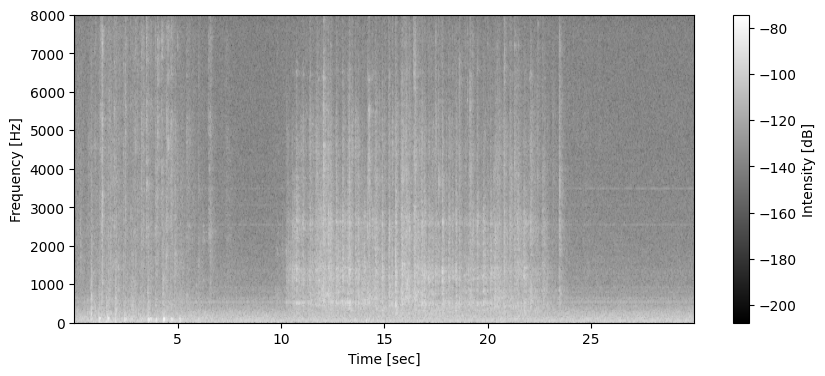

In [3]:
file_name = "/home/nishimura-k/audioprocessing/cart_datas/cart_right600toleft600_200_0.wav"
sample_rate = 16000
audio = load_onefile(file_name)

print(audio.shape)
x = np.array(range(audio.shape[1])) / sample_rate

plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1, 1]")
plt.plot(x, audio[0])

fig=plt.figure(figsize=(10, 4))
spectrum, f, t, im=plt.specgram(audio[0], NFFT=512, noverlap=256, Fs=16000, cmap="gray")
fig.colorbar(im).set_label("Intensity [dB]")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.show()

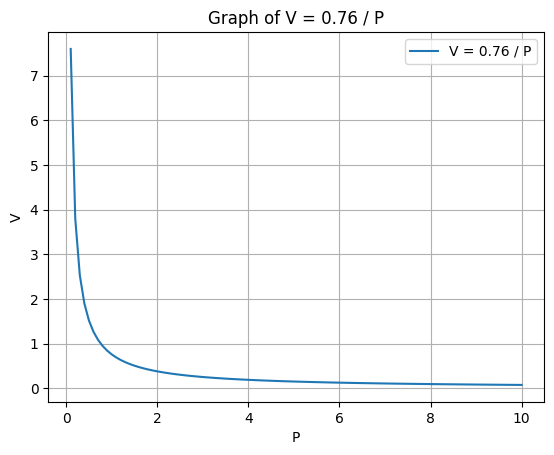

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Pの範囲を設定 (例えば、0.1から10まで)
P = np.linspace(0.1, 10, 100)  # 0.1から10までの100個の値

# Vの計算
V = 0.76 / P

# グラフの描画
plt.plot(P, V, label="V = 0.76 / P")
plt.xlabel("P")
plt.ylabel("V")
plt.title("Graph of V = 0.76 / P")
plt.legend()
plt.grid(True)
plt.show()